In [393]:
%matplotlib inline

import pandas as pd
# Show all rows
pd.set_option('display.max_rows', None)

# Show all columns
pd.set_option('display.max_columns', None)

# Show full column contents (no truncation)
pd.set_option('display.max_colwidth', None)

# Don’t wrap long output lines
pd.set_option('display.expand_frame_repr', False)

import numpy as np
import altair as alt
import re
import os
import matplotlib.pyplot as plt
from langdetect import detect, DetectorFactory
from itertools import cycle, islice
import dtale

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

import project_fuctions as functions
DetectorFactory.seed = 42

alt.data_transformers.disable_max_rows()


DataTransformerRegistry.enable('default')

## Reading data

In [394]:
artists_path = 'data\\artists.csv'
tracks_path = 'data\\tracks.csv'

This code automatically detects the correct separator for two dataset files (tracks and artists) by checking which character — comma, semicolon, or tab — appears most in the first line. It then loads each file into a pandas DataFrame using the detected separator, prints their shapes, and displays the first few rows.

 The tracks dataset has 11,166 rows and 45 columns, while the artists dataset has 104 rows and 14 columns.

In [395]:
# Funzione helper per capire il separatore corretto
def detect_separator(filepath):
    with open(filepath, 'r', encoding='utf-8') as f:
        sample = f.readline()
    # Conta quanti separatori compaiono
    seps = {',': sample.count(','), ';': sample.count(';'), '\t': sample.count('\t')}
    best_sep = max(seps, key=seps.get)
    print(f"Detected separator for {filepath}: '{best_sep}'")
    return best_sep

# Rileva automaticamente il separatore
sep_tracks = detect_separator(tracks_path)
sep_artists = detect_separator(artists_path)

print('------------------------------------')

# Carica i dataset in base al separatore rilevato
tracks = pd.read_csv(tracks_path, sep=sep_tracks, encoding='utf-8', engine='python')
artists = pd.read_csv(artists_path, sep=sep_artists, encoding='utf-8', engine='python')

df = tracks.merge(
    artists,
    left_on="id_artist",
    right_on="id_author",
    how="left",
    suffixes=("", "_artist")
)

# Mostra alcune info per verifica
print(f"Tracks shape: {tracks.shape}")
print(f"Artists shape: {artists.shape}")
print("Shape df (merged):", df.shape)
print('------------------------------------')

print('TRACKS')
display(tracks.head(3))

print('------------------------------------')
print('ARTISTS')
display(artists.head(3))

print('------------------------------------')
print('MERGERD')
display(df.head(3))

Detected separator for data\tracks.csv: ','
Detected separator for data\artists.csv: ';'
------------------------------------
Tracks shape: (11166, 45)
Artists shape: (104, 14)
Shape df (merged): (11166, 59)
------------------------------------
TRACKS


id    id_artist    name_artist                                                full_title         title     featured_artists primary_artist language             album  stats_pageviews  swear_IT  swear_EN                                                                          swear_IT_words                                    swear_EN_words    year  month   day  n_sentences  n_tokens  tokens_per_sent  char_per_tok  lexical_density  avg_token_per_clause     bpm  centroid    rolloff    flux     rms     zcr  flatness  spectral_complexity      pitch  loudness        album_name album_release_date album_type  disc_number  track_number  duration_ms explicit popularity                                                       album_image   id_album                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        

------------------------------------
ARTISTS


,id_author,name,gender,birth_date,birth_place,nationality,description,active_start,active_end,province,region,country,latitude,longitude
0,ART82291002,99 posse,M,NaN,NaN,NaN,gruppo musicale italiano,1991-01-01,NaN,NaN,NaN,NaN,NaN,NaN
1,ART53496045,achille lauro,M,1990-07-11,Verona,Italia,cantautore e rapper italiano (1990-),2012-01-01,NaN,Verona,Veneto,Italia,45.442498,10.985738
2,ART18853907,alfa,M,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


------------------------------------
MERGERD


id    id_artist    name_artist                                                full_title         title     featured_artists primary_artist language             album  stats_pageviews  swear_IT  swear_EN                                                                          swear_IT_words                                    swear_EN_words    year  month   day  n_sentences  n_tokens  tokens_per_sent  char_per_tok  lexical_density  avg_token_per_clause     bpm  centroid    rolloff    flux     rms     zcr  flatness  spectral_complexity      pitch  loudness        album_name album_release_date album_type  disc_number  track_number  duration_ms explicit popularity                                                       album_image   id_album                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        

## DATA CLEANING

### Fixing duplicates

#### Fixing Duplicated Tracks Id
After reviewing the songs associated with the duplicated IDs, we found that each duplicated ID corresponds to different songs, except for one case that will be treated later. Therefore, the most reasonable solution is to modify the duplicated IDs by appending the row number to each one. This approach ensures that all songs are preserved while maintaining unique identifiers for every track.

In [396]:
# Identify duplicated IDs
duplicate_mask = tracks.duplicated(subset='id', keep=False)

# Assign new unique IDs only to duplicated rows
tracks.loc[duplicate_mask, 'id'] = (
    tracks.loc[duplicate_mask]
    .apply(lambda x: f"{x['id']}_{x.name}", axis=1)
)


print("Example of updated duplicates:")
display(tracks[duplicate_mask][['id', 'full_title']])


Example of updated duplicates:


,id,full_title
43,TR715264_43,​non è normale by Rosa Chemical
120,TR976686_120,Ibridi by Beba
141,TR230274_141,SaN LoREnZo by Alfa (Ft. Annalisa)
159,TR531651_159,Serenata - From “Forever Out of My League” by Alfa
199,TR898853_199,​oh 9od by thasup (Ft. nayt)
260,TR743448_260,Particolare by thasup
304,TR737119_304,Shawty by Yung Snapp (Ft. ANNA)
510,TR324280_510,Christian Rap RMX (Freestyle) by Lazza
546,TR362754_546,Old man by Nerone
563,TR497887_563,Savage by Nerone (Ft. Highsnob)


##### Duplicated Tracks based on title

#### Fixing duplicate coloums

In this section, we remove all columns that store the same information or redundant representations of it.

##### Primary Artists

In [397]:
# Remove primary_artist column from the dataset
df = df.drop(columns=['primary_artist'])


##### Full title
We are going to take only title

In [398]:
df.drop(columns=['full_title'], inplace=True)

##### Name of the artists
name_artist and name both represent the same entity but name is formatted more accurately, we will retain the name column and drop name_artist for clarity and consistency.

In [399]:
df.drop(columns=['name_artist'], inplace=True)

##### Album
Once we understand that album is more stable than album, we can remove both of these two coloums (album_name and id_album). We remove also album_image because it is useless.

In [400]:
df.drop(columns=['album_name'], inplace=True)
df.drop(columns=['id_album'], inplace=True)
df.drop(columns=['album_image'], inplace=True)

#### Fixing duplicate tracks based on lyrics
As previously identified, there are 9 duplicate rows based on identical lyrics. To maintain data integrity, we will remove these duplicates from the dataset. This step is crucial to prevent skewing any analysis or derived features that rely on the lyrics content.

In [401]:
original_row_count = len(df)
print(f"Original DataFrame shape: {df.shape}")

non_nan_mask = df['lyrics'].notna()
df_nan_lyrics = df[~non_nan_mask]
df_non_nan_lyrics = df[non_nan_mask]

print(f"  > Found {len(df_nan_lyrics)} rows with NaN lyrics (keeping all for now).")
print(f"  > Found {len(df_non_nan_lyrics)} rows with non-NaN lyrics (checking for duplicates).")

duplicate_mask = df_non_nan_lyrics.duplicated(subset=['lyrics', 'album_type'], keep='first')

indices_to_drop = df_non_nan_lyrics[duplicate_mask].index

print(f"  > Found {len(indices_to_drop)} true logical duplicates (same lyrics AND album_type) to remove.")

df.drop(indices_to_drop, inplace=True)

cleaned_row_count = len(df)
rows_removed_total = original_row_count - cleaned_row_count

print(f"\nDataFrame shape after dropping logical duplicates: {df.shape}")
print(f"Total rows removed: {rows_removed_total}")

# We now expect a smaller number (e.g., 8 instead of 10) because
# the 'Madame' tracks (and any others with different album_type) were kept.
print(f"SUCCESS: Removed {rows_removed_total} rows. Duplicates with different 'album_type' were kept.")



Original DataFrame shape: (11166, 53)
  > Found 3 rows with NaN lyrics (keeping all for now).
  > Found 11163 rows with non-NaN lyrics (checking for duplicates).
  > Found 8 true logical duplicates (same lyrics AND album_type) to remove.

DataFrame shape after dropping logical duplicates: (11158, 53)
Total rows removed: 8
SUCCESS: Removed 8 rows. Duplicates with different 'album_type' were kept.


### Fixing DataTypes

In [402]:
# coverting birth_date to dateTime   
date_cols = ['birth_date',  ]
for col in date_cols:
    df[col] = pd.to_datetime(df[col], errors='coerce')  # convert to datetime, invalid dates become NaT

#--------------------------------------------------------------------------------------------------------#



#Converting active_start to dateTime
date_cols = [ 'active_start', ]
for col in date_cols:
    df[col] = pd.to_datetime(df[col], errors='coerce')  # convert to datetime, invalid dates become NaT


#--------------------------------------------------------------------------------------------------------#

#converting album_release_date to DateTime
date_cols = ['album_release_date']
# --- Check date columns ---
for col in date_cols:
    original = df[col].copy()
    converted = pd.to_datetime(original, errors='coerce')
    non_convertible = original[original.notna() & converted.isna()]
    
    print(f"\nColumn '{col}'  entries that cannot be converted to datetime:")
    if not non_convertible.empty:
        for idx, val in non_convertible.items():
            print(f"Row {idx}: {val}")
    else:
        print("All non-missing entries can be converted to datetime.")
    print('----------------------------------------------------------------')
    
# Converting to DateTime
def fix_year_only_dates(val):
    """
    If the value looks like a 4-digit year, convert it to 'YYYY-01-01'.
    Otherwise, return the original value.
    """
    if pd.isna(val):
        return val
    val_str = str(val).strip()
    if re.fullmatch(r'\d{4}', val_str):
        return f"{val_str}-01-01"
    return val_str

# Apply to album_release_date
df['album_release_date'] = df['album_release_date'].apply(fix_year_only_dates)

# Convert album_release_date to datetime
df['album_release_date'] = pd.to_datetime(df['album_release_date'], errors='coerce')

 # Convert year  to number
df['year'] = pd.to_numeric(df['year'], errors='coerce') 
df.info()




Column 'album_release_date'  entries that cannot be converted to datetime:
Row 283: 2013
Row 443: 1955
Row 1101: 2010
Row 1113: 2010
Row 1547: 2004
Row 1549: 2000
Row 1562: 2000
Row 1574: 1998
Row 1581: 2001
Row 1592: 2004
Row 1601: 2004
Row 1615: 2004
Row 1616: 2004
Row 1617: 2004
Row 1618: 2004
Row 1620: 2004
Row 1621: 2004
Row 1622: 2004
Row 1623: 1998
Row 1625: 2004
Row 1626: 1998
Row 1627: 2004
Row 1628: 2004
Row 1951: 1995
Row 1957: 1995
Row 1960: 1995
Row 1964: 1995
Row 1966: 1995
Row 1967: 1995
Row 1971: 1995
Row 1972: 1995
Row 1973: 1995
Row 1982: 1995
Row 2016: 2002
Row 2018: 2002
Row 2024: 2002
Row 2030: 2002
Row 2033: 2002
Row 2040: 2007
Row 2051: 2002
Row 2052: 2007
Row 2064: 2007
Row 2070: 2007
Row 2071: 2002
Row 2078: 2002
Row 2079: 2002
Row 2091: 2007
Row 2096: 2002
Row 2098: 2002
Row 2103: 2007
Row 2107: 2002
Row 2109: 2007
Row 2118: 2002
Row 2121: 2007
Row 2126: 2002
Row 2127: 2007
Row 2132: 2007
Row 2134: 2007
Row 2143: 2002
Row 2147: 2007
Row 2157: 2007
Row 2162: 2

### Filling Missing Value

#### Active End

It is a complete empy coloum so we can delete it.

In [403]:
df.drop(columns=['active_end'], inplace=True)

#### Stats Pageviews

In [404]:
df.drop(columns=['stats_pageviews'], inplace=True)

#### Features Artists

In [405]:
df.drop(columns=['featured_artists'], inplace=True)

#### Popularity


In [406]:
display(
    df.loc[
        (df['popularity'].isna()),
        ['popularity', 'title']
    ].head(50)
)
print(f"We have {df['popularity'].isna().sum()} null value in popularity")

,popularity,title
3716,NaN,Voci di Piazza
3737,NaN,Mattatoy


We have 2 null value in popularity


Given that the popularity score is a continuous metric with skewed distribution and that dropping rows would remove valuable tracks, we opted for median-based imputation.

In [407]:
df['popularity'] = pd.to_numeric(df['popularity'], errors='coerce')

df['popularity_missing_flag'] = df['popularity'].isna().astype(int)
median_pop = df['popularity'].median()
df['popularity'] = df['popularity'].fillna(median_pop)


#### Filling Birth Dates
This code manually fills missing birth dates for specific artists in the dataset. It first defines a dictionary mapping artist names to their known or estimated birth dates.

9 entries couldn’t be filled so their birth dates are intentionally left blank in the dictionary. For Miss Keta, the birth date is unknown, so no accurate value can be provided. The others — Bushwaka, Sottotono, Dark Polo Gang, Cor Veleno, Colle Der Fomento, Club Dogo, Articolo 31, and 99 Posse — are all music groups or duos, not individual artists, meaning they don’t have a single birth date associated with them.

In [408]:
# --- 1. Define the Missing Dates as a Dictionary ---
# Source of truth for the manual fill
birth_dates_to_fill = {
    'alfa': '2000-08-22',
    'anna pepe': '2003-08-15',
    'beba': '1994-10-10',
    'bigmama': '2000-03-10',
    'brusco': '1974-01-04',
    'caneda': '1976-09-30',
    'dargen d_amico': '1980-11-29',
    'guè pequeno': '1980-12-25',
    'johnny marsiglia': '1986-08-05',
    'nerone': '1991-05-23',
    'priestess': '1996-08-20',
    'samuel heron': '1991-01-01',
    'shiva': '1999-08-27',
    'yeиdry': '1993-07-27',
    'o zulù': '1970-11-15',
    'skioffi':'1992-06-05',
    'eva rea':'1993-01-01',
    'hindaco':'1996-01-01',
    'joey funboy':'1995-01-01',
    'mistico':'1982-01-01',
    'mike24':'1985-08-02',
    'doll kill':'1996-01-01',
    'miss simpatia':'1986-03-23',
    'miss keta':'',#unknown
    'bushwaka':'',#duo
    'sottotono':'',#group
    'dark polo gang':'',#group
    'cor veleno':'',#group
    'colle der fomento':'',#group
    'club dogo':'',#group
    'articolo 31':'',#group
    '99 posse':''#gruppo
    }

# --- 2. Fill the Missing Data (Imputation) ---

# Convert the dictionary to a Pandas Series for easy lookup and indexing
birth_date_series = pd.Series(birth_dates_to_fill)

# Iterate through the artists in your fill list and update the DataFrame
for artist, bday in birth_date_series.items():
    # Use .loc to find rows where 'artist_name' matches and update 'birth_date'
    # The second part of the condition (artist_df['birth_date'].isna()) ensures
    # we only overwrite if the date was previously missing (NaN).
    df.loc[
        (df['name'] == artist) & (df['birth_date'].isna()),
        'birth_date'
    ] = bday

# --- 3. Final Conversion and Verification ---

# Convert the 'birth_date' column to the proper datetime format again
# (This is crucial for accurate age calculation)
df['birth_date'] = pd.to_datetime(df['birth_date'], errors='coerce')

# Optional: Print out the affected rows to verify the fix
print("--- Verification of Filled Birth Dates  ---")
# Filter the DataFrame to show only the artists we just updated
filled_artists = df[df['name'].isin(birth_dates_to_fill.keys())]

# Show the unique artist names and their newly filled birth dates
print(filled_artists[['name', 'birth_date']].drop_duplicates().to_string(index=False))

--- Verification of Filled Birth Dates  ---
             name birth_date
             beba 1994-10-10
             alfa 2000-08-22
           nerone 1991-05-23
      guè pequeno 1980-12-25
          skioffi 1992-06-05
        club dogo        NaT
          hindaco 1996-01-01
    miss simpatia 1986-03-23
          eva rea 1993-01-01
           o zulù 1970-11-15
        doll kill 1996-01-01
           yeиdry 1993-07-27
 johnny marsiglia 1986-08-05
      articolo 31        NaT
          mistico 1982-01-01
        miss keta        NaT
   dargen d_amico 1980-11-29
         bushwaka        NaT
         99 posse        NaT
          bigmama 2000-03-10
           brusco 1974-01-04
       cor veleno        NaT
           mike24 1985-08-02
   dark polo gang        NaT
colle der fomento        NaT
        sottotono        NaT
        anna pepe 2003-08-15
     samuel heron 1991-01-01
      joey funboy 1995-01-01
        priestess 1996-08-20
            shiva 1999-08-27
           caneda 1976-09-30

##### Checking distribution after filling Bithdate


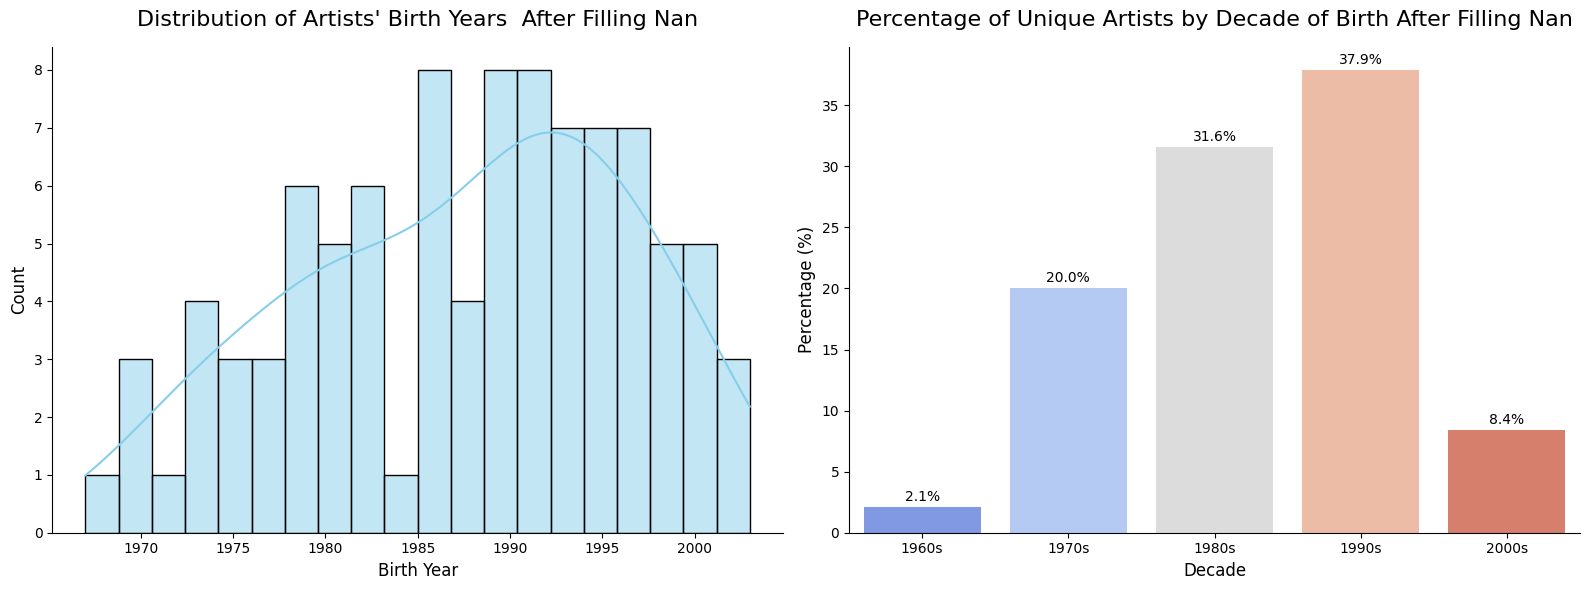

Number of unique artists per age:
birth_date
22    1
23    2
24    2
25    3
26    2
27    3
28    3
29    4
30    2
31    5
32    7
33    3
34    5
35    2
36    6
37    2
38    2
39    4
40    4
41    1
42    2
43    4
44    1
45    4
46    6
49    3
50    3
51    1
52    3
53    1
55    2
56    1
58    1
Name: count, dtype: int64


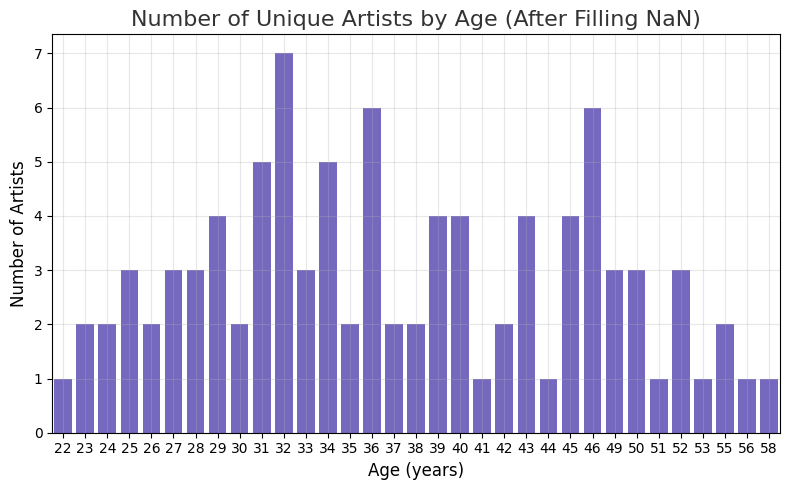

In [409]:
functions.plot_birth_decades(df, "Distribution of Artists' Birth Years  After Filling Nan",'Percentage of Unique Artists by Decade of Birth After Filling Nan')
functions.plot_artist_ages(df,'Number of Unique Artists by Age (After Filling NaN)')

#### Filling Active Start Date

Active start dates have been filled in the 'active_start' column.
Percentage of Unique Artists by Active Start Decade After Filling Missing Values
  decade    percent
0  1980s   2.884615
1  1990s  27.884615
2  2000s  26.923077
3  2010s  38.461538
4  2020s   3.846154


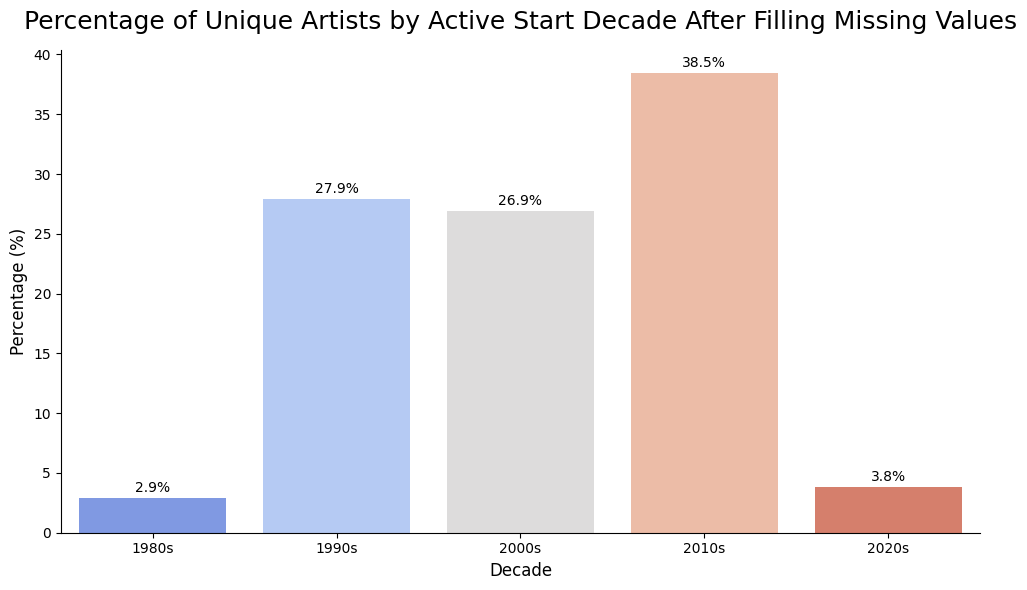

Age of unique Artists When They Started Their Career After Filling Missing Values
1      1
7      1
10     1
13     1
14     4
15     8
16     5
17    14
18    12
19    12
20     6
21    12
22     4
23     4
24     7
26     2
27     1
Name: count, dtype: int64


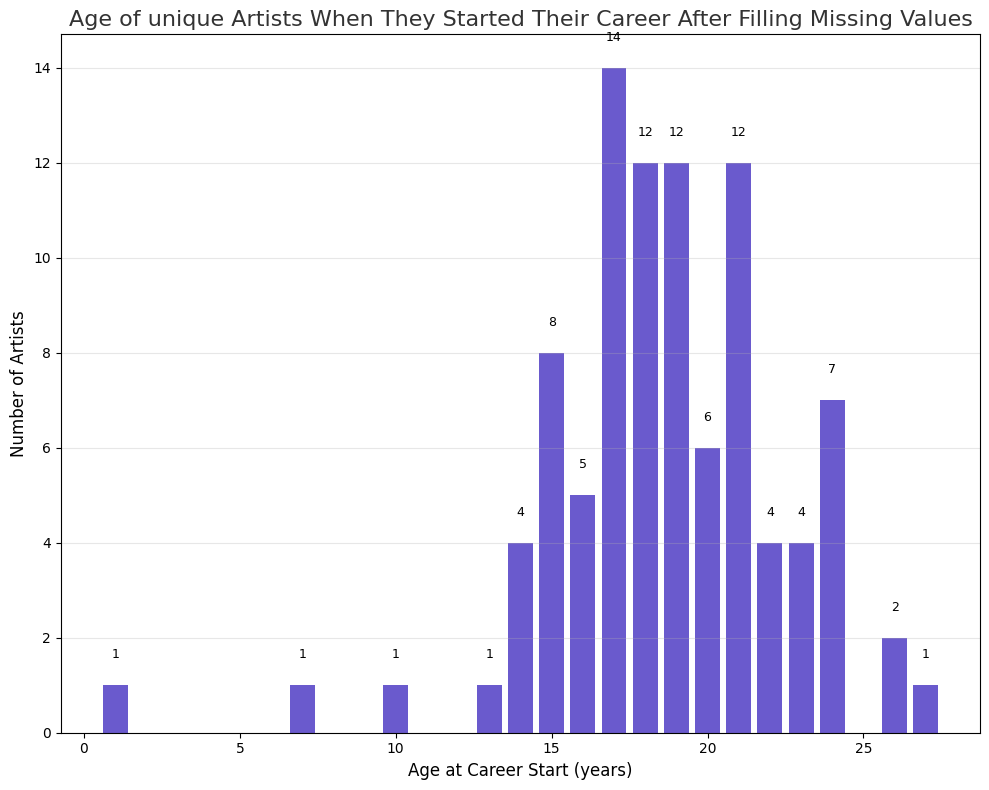

In [410]:
# Total number of unique artists missing 'active_start': 54
active_starts_consolidated = {
    'alfa': '01-15-2017',
    'anna pepe': '01-01-2018',
    'babaman': '01-01-1989',
    'beba': '11-01-2015',
    'brusco': '01-01-1991',
    'capo plaza': '01-01-2013',
    'chadia rodriguez': '01-01-2017',
    'clementino': '04-29-2006',
    'dargen d_amico': '01-01-1999',
    'don joe': '01-01-1999',
    'fred de palma': '01-01-2008',
    'geolier': '01-01-2018',
    'guè pequeno': '01-01-1997',
    'miss keta': '01-01-2013',
    'shiva': '01-01-2014',
    'tedua': '01-01-2013',
    'tony effe': '01-01-2014',
    'sottotono': '01-01-1994',
    'bushwaka': '01-01-2007',
    'mike24': '01-01-2009',
    'mistico': '01-01-2008',
    'skioffi': '01-01-2014',
    "caneda": "01-01-1993",
    "club dogo": "01-01-2002",
    "colle der fomento": "01-01-1994",
    "dani faiv": "01-01-2014",
    "doll kill": "01-01-2012",
    "drefgold": "01-01-2012",
    "entics": "01-01-2004",
    "eva rea": "12-18-2014",
    "hell raton": "01-01-2010",
    "hindaco": "02-21-2020",
    "jack the smoker": "01-01-2000",
    "joey funboy": "01-01-2016",
    "johnny marsiglia": "01-01-2007",
    "la pina": "01-01-1994",
    "luchè": "01-01-1997",
    "mambolosco": "02-10-2017",
    "massimo pericolo": "01-01-2016",
    "miss simpatia": "01-01-2007",
    "mistaman": "01-01-1994",
    "mondo marcio": "01-01-2003",
    "nerone": "01-01-2008",
    "niky savage": "01-01-2021",
    "o zulù": "01-01-1991",
    "papa v": "01-01-2020",
    "rondodasosa": "01-01-2020",
    "samuel heron": "01-01-2012",
    "shablo": "01-01-1999",
    "slait": "01-01-2010",
    "tony boy": "01-01-2018",
    "tormento": "01-01-1991",
    "yeиdry": "01-01-2012",
    "yung snapp": "01-01-2012",
}


# Convert the dictionary to a Pandas Series for efficient filling
start_date_series = pd.Series(active_starts_consolidated)

# Iterate and fill the missing data in the 'active_start' column
for artist, start_date in start_date_series.items():
    # Use .loc to find rows where 'artist_name' matches and update 'active_start'
    df.loc[
        df['name'] == artist,
        'active_start'
    ] = start_date

# Ensure the 'active_start' column is a proper datetime object
df['active_start'] = pd.to_datetime(df['active_start'], errors='coerce')

print("Active start dates have been filled in the 'active_start' column.")

functions.plot_active_start_decades(df,'Percentage of Unique Artists by Active Start Decade After Filling Missing Values')
functions.plot_age_at_career_start(df,'Age of unique Artists When They Started Their Career After Filling Missing Values')

#### Adding Album_release_date for albums that doesn't have date (todooo)

In [411]:
##todoooo

#### Filling missing albums for tracks (REDooo)
We have 78 tracks without albums. We managed to find the albums for 16 tracks.

In [412]:
# # --- 1. Define mapping for known tracks ---
# # Keys = track title (partial or exact match)
# # Values = album name, release date, and type
# album_updates = {

#     "PTS (PoiTiSpiego/PostTraumaticStress)": {
#         "album_name": "Gilmar / Embrionale",
#         "album_release_date": "2012-01-01",
#         "album_type": "album"
#     },
#     "Quelli che benpensano": {
#         "album_name": "La morte dei miracoli",
#         "album_release_date": "1997-01-01",
#         "album_type": "album"
#     },
#     "Autodafè": {
#         "album_name": "La morte dei miracoli",
#         "album_release_date": "1997-01-01",
#         "album_type": "album"
#     },
#     "Fight da faida": {
#         "album_name": "La morte dei miracoli",
#         "album_release_date": "1997-01-01",
#         "album_type": "album"
#     },
#     "Giù le mani da Caino": {
#         "album_name": "La morte dei miracoli",
#         "album_release_date": "1997-01-01",
#         "album_type": "album"
#     },
#     "Pedala": {
#         "album_name": "La morte dei miracoli",
#         "album_release_date": "1997-01-01",
#         "album_type": "album"
#     },
#     "Accendimi": {
#         "album_name": "La morte dei miracoli",
#         "album_release_date": "1997-01-01",
#         "album_type": "album"
#     },
#     "Fili": {
#         "album_name": "La morte dei miracoli",
#         "album_release_date": "1997-01-01",
#         "album_type": "album"
#     },
#     "Rap Lamento": {
#         "album_name": "La morte dei miracoli",
#         "album_release_date": "1997-01-01",
#         "album_type": "album"
#     },
#     "Cali di tensione": {
#         "album_name": "La morte dei miracoli",
#         "album_release_date": "1997-01-01",
#         "album_type": "album"
#     },
#     "Cubetti tricolori": {
#         "album_name": "La morte dei miracoli",
#         "album_release_date": "1997-01-01",
#         "album_type": "album"
#     },
#     "Faccio la mia cosa": {
#         "album_name": "La morte dei miracoli",
#         "album_release_date": "1997-01-01",
#         "album_type": "album"
#     },
#     "Libri Di Sangue": {
#         "album_name": "La morte dei miracoli",
#         "album_release_date": "1997-01-01",
#         "album_type": "album"
#     },
#     "Potere Alla Parola": {
#         "album_name": "La morte dei miracoli",
#         "album_release_date": "1997-01-01",
#         "album_type": "album"
#     },
#     "Nuvole": {
#         "album_name": "La morte dei miracoli",
#         "album_release_date": "1997-01-01",
#         "album_type": "album"
#     },
#     "Il beat come anestetico": {
#         "album_name": "La morte dei miracoli",
#         "album_release_date": "1997-01-01",
#         "album_type": "album"
#     },
# }

# # --- 2. Define a helper function to safely update missing info ---
# def update_album_info(row):
#     for track, info in album_updates.items():
#         if track.lower() in str(row['title']).lower():  # partial match, case-insensitive
#             if pd.isna(row['album_name']):
#                 row['album_name'] = info['album_name']
#             if pd.isna(row['album_release_date']):
#                 row['album_release_date'] = pd.to_datetime(info['album_release_date'])
#             if pd.isna(row['album_type']):
#                 row['album_type'] = info['album_type']
#             break
#     return row

# # --- 3. Apply to the dataset ---
# df = df.apply(update_album_info, axis=1)

# # --- 4. Verify the updates ---
# updated = df[df['title'].str.contains('|'.join(album_updates.keys()), case=False, na=False)]
# print(f" Updated {len(updated)} tracks with album information.")
# display(updated[['title', 'album_name', 'album_release_date', 'album_type']])

#### Artist Location Info

In [413]:
def impute_all_artist_data(df):
    """
    Performs comprehensive imputation of all missing biographical fields,
    including Latitude and Longitude coordinates, for the Italian artist dataset.

    The function relies on a manually curated knowledge base (IMPUTATION_MAP).
    """
    df = df.copy()

    # 1. Define the Master Imputation Map with Coordinates
    # Value: (Birth Place, Nationality, Country, Province, Region, Latitude, Longitude)
    IMPUTATION_MAP = {
        'articolo 31': ('Milano', 'Italia', 'Italia', 'Milano', 'Lombardia', 45.4642, 9.1900),
        'bushwaka': ('Milano', 'Italia', 'Italia', 'Milano', 'Lombardia', 45.4642, 9.1900),
        'club dogo': ('Milano', 'Italia', 'Italia', 'Milano', 'Lombardia', 45.4642, 9.1900),
        'dargen d_amico': ('Milano', 'Italia', 'Italia', 'Milano', 'Lombardia', 45.4642, 9.1900),
        'doll kill': ('Milano', 'Italia', 'Italia', 'Milano', 'Lombardia', 45.4642, 9.1900),
        'guè pequeno': ('Milano', 'Italia', 'Italia', 'Milano', 'Lombardia', 45.4642, 9.1900),
        'miss keta': ('Milano', 'Italia', 'Italia', 'Milano', 'Lombardia', 45.4642, 9.1900),
        'nerone': ('Milano', 'Italia', 'Italia', 'Milano', 'Lombardia', 45.4642, 9.1900),
        'shiva': ('Milano', 'Italia', 'Italia', 'Milano', 'Lombardia', 45.4642, 9.1900),
        'niky savage': ('Milano', 'Italia', 'Italia', 'Milano', 'Lombardia', 45.4642, 9.1900),

        # --- ROMA (Lazio) ---
        'brusco': ('Roma', 'Italia', 'Italia', 'Roma', 'Lazio', 41.8933, 12.4829),
        'colle der fomento': ('Roma', 'Italia', 'Italia', 'Roma', 'Lazio', 41.8933, 12.4829),
        'cor veleno': ('Roma', 'Italia', 'Italia', 'Roma', 'Lazio', 41.8933, 12.4829),
        'mistico': ('Roma', 'Italia', 'Italia', 'Roma', 'Lazio', 41.8933, 12.4829),
        'dark polo gang':('Roma', 'Italia', 'Italia', 'Roma', 'Lazio', 41.8933, 12.4829),

        # --- NAPOLI (Campania) ---
        '99 posse': ('Napoli', 'Italia', 'Italia', 'Napoli', 'Campania', 40.8518, 14.2681),
        'o zulù': ('Napoli', 'Italia', 'Italia', 'Napoli', 'Campania', 40.8518, 14.2681),
        'bigmama': ('Avellino', 'Italia', 'Italia', 'Avellino', 'Campania', 40.9167, 14.7833),
        'eva rea': ('Napoli', 'Italia', 'Italia', 'Napoli', 'Campania', 40.8518, 14.2681),
        'joey funboy': ('Napoli', 'Italia', 'Italia', 'Napoli', 'Campania', 40.8518, 14.2681),
        'mike24': ('Napoli', 'Italia', 'Italia', 'Napoli', 'Campania', 40.8518, 14.2681),
        'miss simpatia': ('Napoli', 'Italia', 'Italia', 'Napoli', 'Campania', 40.8518, 14.2681),
        'samuel heron': ('Napoli', 'Italia', 'Italia', 'Napoli', 'Campania', 40.8518, 14.2681),

        # --- Other Regions/Cities ---
        'beba': ('Torino', 'Italia', 'Italia', 'Torino', 'Piemonte', 45.0703, 7.6869),
        'alfa': ('Genova', 'Italia', 'Italia', 'Genova', 'Liguria', 44.4073, 8.9463),
        'anna pepe': ('La Spezia', 'Italia', 'Italia', 'La Spezia', 'Liguria', 44.1027, 9.8252),
        'caneda': ('Varese', 'Italia', 'Italia', 'Varese', 'Lombardia', 45.8197, 8.8256),
        'fabri fibra': ('Senigallia', 'Italia', 'Italia', 'Ancona', 'Marche', 43.7126, 13.2201),
        'nesli': ('Senigallia', 'Italia', 'Italia', 'Ancona', 'Marche', 43.7126, 13.2201),
        'hindaco': ('Padova', 'Italia', 'Italia', 'Padova', 'Veneto', 45.4064, 11.8767),
        'johnny marsiglia': ('Palermo', 'Italia', 'Italia', 'Palermo', 'Sicilia', 38.1157, 13.3615),
        'priestess': ('Palermo', 'Italia', 'Italia', 'Palermo', 'Sicilia', 38.1157, 13.3615),
        'skioffi': ('Taranto', 'Italia', 'Italia', 'Taranto', 'Puglia', 40.4667, 17.2403),
        'sottotono': ('Varese', 'Italia', 'Italia', 'Varese', 'Lombardia', 45.8197, 8.8256),

        # --- International ---
        'baby k': ('Singapore', 'Italia', 'Singapore', np.nan, np.nan, 1.3521, 103.8198),
        'shablo': ('Buenos Aires', 'Argentina', 'Argentina', np.nan, np.nan, -34.6037, -58.3816),
        'yeиdry': ('Santo Domingo', 'Dominicana', 'Dominican Republic', np.nan, np.nan, 18.4861, -69.9312),

    }

    # 2. Add Latitude and Longitude columns if they don't exist
    for col in ['latitude', 'longitude']:
        if col not in df.columns:
            df[col] = np.nan

    # 3. Iterate and Apply Imputation/Fill Missing Values
    for index, row in df.iterrows():
        artist = row['name']

        if artist in IMPUTATION_MAP:
            (birth_place, nationality, country, province, region, lat, lon) = IMPUTATION_MAP[artist]

            # Use fillna() logic: only fill if the current cell is NaN

            # Biographical Imputation
            df.loc[index, 'birth_place'] = row['birth_place'] if pd.notna(row['birth_place']) else birth_place
            df.loc[index, 'nationality'] = row['nationality'] if pd.notna(row['nationality']) else nationality
            df.loc[index, 'country'] = row['country'] if pd.notna(row['country']) else country
            df.loc[index, 'province'] = row['province'] if pd.notna(row['province']) else province
            df.loc[index, 'region'] = row['region'] if pd.notna(row['region']) else region

            # Geospatial Imputation (Always fill the Lat/Lng to ensure consistency with the Birth Place)
            df.loc[index, 'latitude'] = lat
            df.loc[index, 'longitude'] = lon


    return df



df = impute_all_artist_data(df)


print ('checking the left null values after filling')
# Define columns to check
cols_to_check = [
    'birth_place',
    'nationality',
    'province',
    'region',
    'country',
    'latitude',
    'longitude'
]

# Filter rows where any of these columns are null
missing_rows = df[df[cols_to_check].isnull().any(axis=1)]

# Select only artist name + the relevant columns
columns_to_show = ['name'] + cols_to_check
missing_subset = missing_rows[columns_to_show]

# Keep only unique artist names (first occurrence)
unique_missing_subset = missing_subset.drop_duplicates(subset=['name'])

# Show the result in D-Tale
print(unique_missing_subset.shape)
display(unique_missing_subset)

checking the left null values after filling
(3, 8)


,name,birth_place,nationality,province,region,country,latitude,longitude
2798,yeиdry,Santo Domingo,Dominicana,NaN,NaN,Dominican Republic,18.4861,-69.9312
5270,baby k,Singapore,Italia,NaN,NaN,Singapore,1.3521,103.8198
8148,shablo,Buenos Aires,Argentina,NaN,NaN,Argentina,-34.6037,-58.3816


#### Lyrics

In [414]:
print(f"Shape before fixing NaNs: {df.shape}")
original_row_count = len(df)

# Action 1: Drop all rows where 'lyrics' is missing (in-place)
df.dropna(subset=['lyrics'], inplace=True)

rows_removed_lyrics = original_row_count - len(df)
print(f"\nShape after dropping 'lyrics' NaNs: {df.shape}")
print(f"Rows removed: {rows_removed_lyrics}")

if rows_removed_lyrics == 3:
    print("SUCCESS: Correctly removed the 3 'NaN' lyric rows.")
else:
    print(f"WARNING: Expected to remove 3 'NaN' rows, but removed {rows_removed_lyrics}.")

Shape before fixing NaNs: (11158, 51)

Shape after dropping 'lyrics' NaNs: (11155, 51)
Rows removed: 3
SUCCESS: Correctly removed the 3 'NaN' lyric rows.


### Fixing out of range and errors

####  Correcting "Priestess" Entry

Based on the inspection of the artists description above, we noticed an entry labeled “gruppo musicale canadese” (Canadian music group). Upon checking, this description is incorrectly assigned to the Italian rapper Priestess. Further research revealed a mix-up with a Canadian band that shares the same name. This confusion becomes evident when comparing the active_start year in the dataset, which matches that of the Canadian group rather than the Italian artist.

We are going to correct its data

In [415]:
print('Before')
display( df[df['description'].str.contains('gruppo musicale canadese', case=False, na=False)]
         .drop_duplicates(subset=['name'])
         .sort_values(by='name'))

print('After')
# Fix Priestess' incorrect description and active_start date
df.loc[df['name'].str.lower() == 'priestess', ['description','active_start' ]] = [
    'cantante e rapper italiana',
    '2017-01-01'

]

# Verify the update
print(df[df['name'].str.lower() == 'priestess'][['name', 'description', 'active_start']])


Before


,id,id_artist,title,language,album,swear_IT,swear_EN,swear_IT_words,swear_EN_words,year,month,day,n_sentences,n_tokens,tokens_per_sent,char_per_tok,lexical_density,avg_token_per_clause,bpm,centroid,rolloff,flux,rms,zcr,flatness,spectral_complexity,pitch,loudness,album_release_date,album_type,disc_number,track_number,duration_ms,explicit,popularity,lyrics,modified_popularity,id_author,name,gender,birth_date,birth_place,nationality,description,active_start,province,region,country,latitude,longitude,popularity_missing_flag
9797,TR874555,ART87389753,Maria Antonietta,it,Torno domani - EP,1,0,['merda'],[],2017.0,3.0,21.0,57.0,396.0,6.947368,4.075843,0.505618,8.25,112.63,0.1497,2081.3273,1.2331,0.1906,0.0737,0.8085,23.0648,1848.8056,20.2114,2017-03-21,single,1.0,1.0,174159.0,False,25.0,"Camere oscure, sapore di erba\r\nLe canne e i caffè, i vicini son fuori di testa\r\nUn po' come me\r\nAlzo il volume, sotterro i pensieri e la merda\r\nFreddi col cuore, di Svezia\r\nL'ansia, le pare e i cliché\r\nL'ansia, le pare e i cliché\r\nLa mia stella buona sai dov'è?\r\nImpressione fredda di un Monet\r\nLingua dolce, vous parlez français?\r\nLa tristezza, Creme Brulee, l'ultimo dessert\r\nChe non voglio condividere con te\r\nPoi rimango a scrivere fino alle tre\r\n\r\nE se non rispondi, vado fuori di testa\r\nE se mi assecondi, vado fuori di testa\r\nFiori per me, erba per te, noi fuori di testa\r\nFiori per me, erba per te, noi fuori di testa\r\n\r\nHo perso la testa per te\r\nMaria Antonietta, Maria Antonietta\r\nHo perso la testa per te\r\nMaria Antonietta, Maria Antonietta\r\nHo perso la testa per te\r\nMaria Antonietta\r\nHo perso la testa per te\r\nHo perso la testa per te\r\n\r\nE le vedi in giro tutte queste Barbie\r\nTutte uguali, fatte in serie\r\nCon il tipo incamiciato, con i dindin e la fuoriserie\r\nMa, questa sera\r\nEsco e ci sto male\r\nNiente di personale, con in bocca un personale\r\nTra le mani fragranza di hashish\r\nGirane una poi baciami, aspetta mi lasci\r\nNoi siamo ammalati, influenza, tu spero ci passi\r\nFanculo gli altri (Eh)\r\nNoi siamo perfetti, matti, nati per essere fatti\r\nTi tengo stretto non scappi\r\n\r\nE se non rispondi, vado fuori di testa\r\nE se mi assecondi, vado fuori di testa\r\nFiori per me, erba per te, noi fuori di testa\r\nFiori per me, erba per te, noi fuori di testa\r\n\r\nHo perso la testa per te\r\nMaria Antonietta, Maria Antonietta\r\nHo perso la testa per te\r\nMaria Antonietta, Maria Antonietta\r\nHo perso la testa per te\r\nMaria Antonietta\r\nHo perso la testa per te\r\nHo perso la testa per te\r\nHo perso la testa per te\r\nMaria Antonietta, Maria Antonietta\r\nHo perso la testa per te\r\nMaria Antonietta, Maria Antonietta\r\nHo perso la testa per te\r\nMaria Antonietta\r\nHo perso la testa per te\r\nHo perso la testa per te",False,ART87389753,priestess,F,1996-08-20,Palermo,Italia,gruppo musicale canadese,2003-01-01,Palermo,Sicilia,Italia,38.1157,13.3615,0


After
           name                 description active_start
9797  priestess  cantante e rapper italiana   2017-01-01
9798  priestess  cantante e rapper italiana   2017-01-01
9799  priestess  cantante e rapper italiana   2017-01-01
9800  priestess  cantante e rapper italiana   2017-01-01
9801  priestess  cantante e rapper italiana   2017-01-01
9802  priestess  cantante e rapper italiana   2017-01-01
9803  priestess  cantante e rapper italiana   2017-01-01
9804  priestess  cantante e rapper italiana   2017-01-01
9805  priestess  cantante e rapper italiana   2017-01-01
9806  priestess  cantante e rapper italiana   2017-01-01
9807  priestess  cantante e rapper italiana   2017-01-01
9808  priestess  cantante e rapper italiana   2017-01-01
9809  priestess  cantante e rapper italiana   2017-01-01
9810  priestess  cantante e rapper italiana   2017-01-01
9811  priestess  cantante e rapper italiana   2017-01-01
9812  priestess  cantante e rapper italiana   2017-01-01
9813  priestess  cantante

#### Popularity

In [416]:
# Fix out-of-range popularity values
df['popularity'] = df['popularity'].clip(lower=0, upper=100)
#
display(df.loc[df['modified_popularity'] == 1, ['popularity', 'modified_popularity', 'title']].head(50))

,popularity,modified_popularity,title
1932,32.0,True,Ciao ciao 2
2304,32.0,True,Santa Margherita 104 Freestyle
3286,0.0,True,PTS (PoiTiSpiego/PostTraumaticStress)
3667,100.0,True,Quelli che benpensano
3668,100.0,True,Autodafè
3669,32.0,True,Fight da faida
3670,0.0,True,Giù le mani da Caino
3671,100.0,True,Pedala
3672,32.0,True,Accendimi...
3673,32.0,True,Fili


Now we don't need anymore modified_popularity, so we can just drop it.

In [417]:
df.drop(columns=['modified_popularity'], inplace=True)
print("OK — column 'modified_popularity' has been removed.")

OK — column 'modified_popularity' has been removed.


#### Lyrics

##### Remove Junk Lyrics

In [418]:
# maximum tokens for junk lyrics: 36
# minimum tokens for actual lyrics: 108
pattern = 'Contributors|Contributor|Lyrics|COMING SOON|instrumental'

token_threshold = 60  # Safe threshold based on your analysis

# Find the indices of rows that meet BOTH conditions
conditions_to_eliminate = (
        (df['lyrics'].str.contains(pattern, case=False, na=False)) &
        (df['n_tokens'] < token_threshold)
)

# Get the actual index labels of the rows to drop
indices_to_drop = df[conditions_to_eliminate].index
num_to_eliminate = len(indices_to_drop)

print(f"Found {num_to_eliminate} 'junk AND short' rows (< {token_threshold} tokens) to ELIMINATE.")

# 2. Set the 'lyrics' column to NaN where the conditions are true
if num_to_eliminate > 0:
    df.drop(indices_to_drop, inplace=True)

    print(f"DataFrame shape AFTER elimination: {df.shape}")
    print(f"Successfully removed {num_to_eliminate} rows.")


Found 122 'junk AND short' rows (< 60 tokens) to ELIMINATE.
DataFrame shape AFTER elimination: (11033, 50)
Successfully removed 122 rows.


##### Cleaning "Contributors" Headers

In [419]:
contributor_pattern = 'Contributors|Contributor'
contributor_matches = df[df['lyrics'].str.contains(contributor_pattern, case=False, na=False)]

print(f"\nRows containing Contributors words")
print(f"Total number: {len(contributor_matches)}")
if not contributor_matches.empty:
    display(contributor_matches[['id', 'name', 'title', 'lyrics', 'n_tokens']].head(23))


Rows containing Contributors words
Total number: 16


,id,name,title,lyrics,n_tokens
1777,TR372521,clementino,Intro (Napolimanicomio),"5 ContributorsIntro (Napolimanicomio) LyricsIl principio con l'accumulo di stress, poi la disconnessione totale, poi l'arte, il teatro, la musica, le lingue differenti tra loro, il sacrificio, la voglia di farsi ascoltare, gli omicidi, i suicidi, il caso, l'ungella, il lavoro, la moda, la ricerca, le allucinazioni, il rispetto per l'anziano, la legge, la fatica, il telefono, il potere, gli anni che passano, le troppe tasse, il parlamento, la religione, i pregiudizi, la paura del futuro, la routine, la passione, la voglia di stare da solo, la solitudine, i soldi! E così nacque: NAPOLIMANICOMIO!",135.0
1955,TR194183,la pina,Dammi Ancora,"1 ContributorDammi Ancora LyricsNon fare scene, lo sai che ti voglio bene, stasera dormiamo assieme e ci coccoliamo un po' tu sei leale nel bene e nel male fedele totale la cosa più bella che ho tu mi supporti, sopporti, con tutti i rapporti contorti che ho tu mi conforti un bel po' basta una carezza tanto hai la certezza che non so dirti di no manda via i fantasmi mentre dormo, e tienili a bada di giorno e io quando esco ritorno adesso siamo assieme e chi ci tiene? Chi ci divide più, chi ci divide più. occhi che sai già che tornano non mi lasciano, non mi tradiranno mai come nessuno mi ha voluto mai dammi tanto quanto ti darò dammi ancora. Mi ricompensi, con quei sospiri immensi, intensi sguardi ma non mi parli, vorrei sapere a cosa pensi se tu sapessi ma non conosci pena e pietà, fai parte di un'altra realtà mi commuovi, occhi buoni non porti rancori, perdoni a priori vai fuori per me ogni gesto spinto dall'istinto per questo mai finto, per questo mi hai vinto A cosa pensi? Dimmi a cosa pensi perché non lo so che cosa sogni? Dimmi cosa sogni perché non lo so Dimmi quanti baci vuoi che te li do non ti stanchi mai, però, senza che farei? Sei il primo sorriso al mattino l'ultima faccia stropiccia il cuscino è questo che traccia un destino Occhi che sai già che tornano non mi lasciano, non mi tradiranno mai come nessuno mi ha voluto mai dammi tanto quanto ti darò dammi ancora. Dammi, dammi ancora, non so come ho fatto finora, sei tanta roba io non conosco una sola persona più buona, che mi approva e consola o che almeno ci prova come ci provi tu dammi, dammi ancora con la stessa foga mangiami la noia, che non ne potevo più tu c'hai quel qualcosa, quella pazza gioia contagiosa è che sono solo un po' invidiosa perché c'hai la coda! Occhi che sai già che tornano non mi lasciano, non mi tradiranno mai come nessuno mi ha voluto mai dammi tanto quanto ti darò dammi ancora. Questa è speciale per Marvin e Cora …. Occhi che sai già che tornano non mi lasciano, non mi tradiranno mai come nessuno mi ha voluto mai dammi tanto quanto ti darò dammi ancora",437.0
1968,TR415938,la pina,Cin Cin,1 ContributorCin Cin LyricsIo non so come fai di che parli se non sai mentre tu pensi a me sempre nei pensieri tuoi sappi che dento ai miei tu non ti ci trovi mai io non so come stai non me lo domando mai Cin Cin sotto i colpi bassi di un aperitivo passa un altro assente ignaro propongo un brindisi alla sincerità dei vostri sorrisi amici meravigliosi so che chi si espone e' bersaglio la mira si prende meglio e ti godi il dettaglio ma io non accetto critiche da chi fa peggio di me acide frigide se ogni mio gesto e' un pretesto per chiaccherare sappiate che non esco perché ho di meglio da fare quindi tenetevi stretti i bicchieri e i giudizi severi state diventando vecchi miei cari Faccio la musica e conduco vita da monaca per la cronaca ogni sei mesi gravida non capisco per quale meccanismo tutte ste creature non le partorisco non sarò una santa ma preferisco il 950 a maschi che non mi soddisfano sono contenta se la mia vita diventa il fulcro di tanta attenzione ma stai attenta il tuo ragazzo mi ha detto che a letto non sei sto ciclone sarà il motivo per cui sei pettegola cocca la tua vita e' squallida Gia' siamo quattro gatti e in più tutti si s

In [420]:
# Remove the found pattern from the beginning of the lyrics
print(f"DataFrame shape BEFORE cleaning: {df.shape}")

indices_to_clean = df[df['lyrics'].str.contains(contributor_pattern, case=False, na=False)].index

print(f"Number of rows to clean: {len(indices_to_clean)}")

if len(indices_to_clean) > 0:
    # Definisci la regex per l'intestazione
    header_regex = r"^\s*\d+\s+Contributor(s)?.*?\s+Lyrics\s*"

    original_lyrics = df.loc[indices_to_clean, 'lyrics']

    cleaned_lyrics_series = original_lyrics.str.replace(
        header_regex, '', regex=True, flags=re.IGNORECASE
    ).str.strip()

    empty_mask = (cleaned_lyrics_series == '') | (cleaned_lyrics_series.str.isspace()) | (cleaned_lyrics_series.isna())
    indices_to_drop = cleaned_lyrics_series[empty_mask].index

    indices_to_update = cleaned_lyrics_series[~empty_mask].index
    updates_to_apply = cleaned_lyrics_series[indices_to_update]

    print(f"  > Identified {len(indices_to_drop)} rows to DROP (lyrics were only the header).")
    print(f"  > Identified {len(indices_to_update)} rows to UPDATE (lyrics were contaminated).")

    # Delete the rows that are now empty
    if not indices_to_drop.empty:
        df.drop(indices_to_drop, inplace=True)
        print(f"  > Dropped {len(indices_to_drop)} 'junk' rows.")

    # Update the rows with cleaned lyrics
    if not indices_to_update.empty:
        df.loc[indices_to_update, 'lyrics'] = updates_to_apply
        print(f"  > Cleaned and updated {len(indices_to_update)} 'contaminated' rows.")

    print(f"\nDataFrame shape AFTER cleaning: {df.shape}")

print("\nVerifying the cleaning (first 5 modified lyrics):")
for index in indices_to_clean[:20]:
    if index in df.index:
        print("==============================================")
        print(f"INDEX: {index}")
        print(f"CLEANED TEXT (preview):\n'{str(df.loc[index, 'lyrics'])[:200]}...'")

DataFrame shape BEFORE cleaning: (11033, 50)
Number of rows to clean: 16
  > Identified 1 rows to DROP (lyrics were only the header).
  > Identified 15 rows to UPDATE (lyrics were contaminated).
  > Dropped 1 'junk' rows.
  > Cleaned and updated 15 'contaminated' rows.

DataFrame shape AFTER cleaning: (11032, 50)

Verifying the cleaning (first 5 modified lyrics):
INDEX: 1777
CLEANED TEXT (preview):
'Il principio con l'accumulo di stress, poi la disconnessione totale, poi l'arte, il teatro, la musica, le lingue differenti tra loro, il sacrificio, la voglia di farsi ascoltare, gli omicidi, i suicid...'
INDEX: 1955
CLEANED TEXT (preview):
'Non fare scene, lo sai che ti voglio bene, stasera dormiamo assieme e ci coccoliamo un po' tu sei leale nel bene e nel male fedele totale la cosa più bella che ho tu mi supporti, sopporti, con tutti i...'
INDEX: 1968
CLEANED TEXT (preview):
'Io non so come fai di che parli se non sai mentre tu pensi a me sempre nei pensieri tuoi sappi che dento ai miei 

##### Cleaning editorial sentences

In [421]:
def remove_editorial_sentences(text):
    if not isinstance(text, str):
        return text

    pattern = (
        r"(Il brano vanta[^\.]*\.?)|"      # frasi tipo "Il brano vanta..."
        r"(La produzione è curata[^\.]*\.?)"  # frasi tipo "La produzione è curata..."
        r"(La produzione è opera di [^\.]*\.?)"
    )

    cleaned = re.sub(pattern, "", text, flags=re.IGNORECASE)
    return cleaned.strip()

df["lyrics"] = df["lyrics"].apply(remove_editorial_sentences)

##### Recalculate _auto features

In [422]:
# Apply the "atomic" counting functions
print("Recalculating n_tokens_auto...")
# We use .loc to ensure we modify the original df
df.loc[:, 'n_tokens_auto'] = df['lyrics'].apply(functions.count_tokens)

print("Recalculating n_sentences_auto...")
df.loc[:, 'n_sentences_auto'] = df['lyrics'].apply(functions.count_sentences)

print("Recalculating n_unique_words_auto...")
df.loc[:, 'n_unique_words_auto'] = df['lyrics'].apply(functions.count_unique_tokens)

print("Recalculating total_chars_auto...")
df.loc[:, 'total_chars_auto'] = df['lyrics'].apply(functions.count_total_token_chars)

# Recalculate Ratios (handling division by zero)
print("Recalculating lexical_density_auto...")
df.loc[:, 'lexical_density_auto'] = np.where(
    df['n_tokens_auto'] == 0, 0.0,
    df['n_unique_words_auto'] / df['n_tokens_auto']
)

print("Recalculating tokens_per_sent_auto...")
df.loc[:, 'tokens_per_sent_auto'] = np.where(
    df['n_sentences_auto'] == 0, 0.0,
    df['n_tokens_auto'] / df['n_sentences_auto']
)

print("Recalculating char_per_tok_auto...")
df.loc[:, 'char_per_tok_auto'] = np.where(
    df['n_tokens_auto'] == 0, 0.0,
    df['total_chars_auto'] / df['n_tokens_auto']
)

print("\n--- RECALCULATION COMPLETE ---")

# Final Verification -
nan_check = df['n_tokens_auto'].isna().sum()
print(f"NaNs in 'n_tokens_auto' (should now be 0): {nan_check}")
if nan_check == 0:
    print("SUCCESS: All 'broken' rows have been fixed.")
else:
    print("WARNING: 'NaN' values still found. Please review the 'lyrics' column for errors.")

print("\nAll derived features are now clean and synchronized with the 'lyrics' column.")

Recalculating n_tokens_auto...
Recalculating n_sentences_auto...
Recalculating n_unique_words_auto...
Recalculating total_chars_auto...
Recalculating lexical_density_auto...
Recalculating tokens_per_sent_auto...
Recalculating char_per_tok_auto...

--- RECALCULATION COMPLETE ---
NaNs in 'n_tokens_auto' (should now be 0): 0
SUCCESS: All 'broken' rows have been fixed.

All derived features are now clean and synchronized with the 'lyrics' column.


In [423]:
print(f"Shape before column cleanup: {df.shape}")
print(f"Columns before cleanup: {df.columns.tolist()}")

# Define Columns to Drop

# These are the original "dirty" features we are replacing
original_dirty_features = [
    'n_tokens',
    'n_sentences',
    'tokens_per_sent',
    'char_per_tok',
    'lexical_density',
    'avg_token_per_clause'
]

# These are the intermediate calculation/helper columns we created
helper_and_match_cols = [
    'n_sentences_match',
    'n_tokens_match',
    'tokens_per_sent_match',
    'char_per_tok_match',
    'lexical_density_match',
    'total_chars_auto',
    'n_unique_words_auto'
]

cols_to_drop = original_dirty_features + helper_and_match_cols
existing_cols_to_drop = [col for col in cols_to_drop if col in df.columns]

print(f"\nDropping {len(existing_cols_to_drop)} old/helper columns...")

#  Drop the old and helper columns
df.drop(columns=existing_cols_to_drop, inplace=True)

print("Old columns dropped.")

# Define Columns to Rename ---

rename_map = {
    'n_tokens_auto': 'n_tokens',
    'n_sentences_auto': 'n_sentences',
    'tokens_per_sent_auto': 'tokens_per_sent',
    'char_per_tok_auto': 'char_per_tok',
    'lexical_density_auto': 'lexical_density'
}

existing_rename_map = {k: v for k, v in rename_map.items() if k in df.columns}

print(f"\nRenaming {len(existing_rename_map)} '_auto' columns to their final names...")

# Rename the '_auto' columns
df.rename(columns=existing_rename_map, inplace=True)

print("Columns successfully renamed.")

print(f"Final DataFrame shape: {df.shape}")
print(f"Final columns: {df.columns.tolist()}")


Shape before column cleanup: (11032, 57)
Columns before cleanup: ['id', 'id_artist', 'title', 'language', 'album', 'swear_IT', 'swear_EN', 'swear_IT_words', 'swear_EN_words', 'year', 'month', 'day', 'n_sentences', 'n_tokens', 'tokens_per_sent', 'char_per_tok', 'lexical_density', 'avg_token_per_clause', 'bpm', 'centroid', 'rolloff', 'flux', 'rms', 'zcr', 'flatness', 'spectral_complexity', 'pitch', 'loudness', 'album_release_date', 'album_type', 'disc_number', 'track_number', 'duration_ms', 'explicit', 'popularity', 'lyrics', 'id_author', 'name', 'gender', 'birth_date', 'birth_place', 'nationality', 'description', 'active_start', 'province', 'region', 'country', 'latitude', 'longitude', 'popularity_missing_flag', 'n_tokens_auto', 'n_sentences_auto', 'n_unique_words_auto', 'total_chars_auto', 'lexical_density_auto', 'tokens_per_sent_auto', 'char_per_tok_auto']

Dropping 8 old/helper columns...
Old columns dropped.

Renaming 5 '_auto' columns to their final names...
Columns successfully re

The avg_token_per_clause feature was removed during the data cleaning process for two primary reasons:

Unreliable Source Data: The calculation of this feature depends on the original n_tokens column. Our feature inspection proved that the original n_tokens column is inconsistent and unreliable (with a >99% mismatch compared to our clean, recalculated n_tokens_auto). This makes any metric derived from it inherently untrustworthy.

Unverifiable Calculation: Unlike simpler metrics like n_tokens_auto or n_sentences_auto (which we could recalculate using regex), accurately identifying grammatical "clauses" (proposizioni) requires complex syntactic NLP parsing. This makes the feature impossible for us to verify or reliably recalculate.

In [424]:
display(df.loc[df['n_tokens'] < 10, ['lyrics', 'n_tokens']])


,lyrics,n_tokens
641,Biggie Paul sopra il beat sta in alto,8
758,violence\r\n rastaman\r\nI don't,5
2671,Inoki\r\nNobiltà di strada,4
3172,"Sfera Ebbasta, Sfera, Ebbasta\r\nBillion Headz",6
3586,"Ehi, oh\r\nVai\r\nChica\r\nE già sai\r\nUh",8
3641,Funky funky funky mentre lo dico (x 4),8
3697,This song is an instrumental,5
3717,This song is an instrumental,5
3723,"Avremo il silenzio delle...""",4
5659,Nun tengo posto pe' mettere \r\n classifiche,6


We decide to remove it.

In [425]:
to_remove = df[df['n_tokens'] < 10].shape[0]
print("Deleted rows:", to_remove)

Deleted rows: 13


#### Languages

Since the language of a track is inherently encoded in its lyrics, automatic language identification allows us to objectively validate the declared label and detect annotation inconsistencies, making it a reliable and justifiable approach for language quality assessment.

In [426]:
def detect_lang(text, idx):
    try:
        if not isinstance(text, str) or len(text.strip()) < 20:
            print(f"[{idx}] Skipped (too short or invalid)")
            return None
        lang = detect(text)
        if idx % 100 == 0:  # stampa ogni 100 per non intasare
            print(f"[{idx}] Detected: {lang}")
        return lang
    except Exception as e:
        print(f"[{idx}] Error: {e}")
        return None

# Applica con indice
df['predicted_language'] = [
    detect_lang(txt, i) for i, txt in enumerate(df['lyrics'])
]
# Confronto con lingua dichiarata
df['language_match'] = df['language'] == df['predicted_language']

# Statistiche
total = len(df)
matches = df['language_match'].sum()
mismatches = total - matches


[0] Detected: it
[100] Detected: it
[200] Detected: it
[300] Detected: it
[400] Detected: it
[500] Detected: it
[600] Detected: it
[700] Detected: it
[800] Detected: it
[900] Detected: it
[1000] Detected: it
[1100] Detected: it
[1200] Detected: it
[1300] Detected: it
[1400] Detected: it
[1500] Detected: it
[1600] Detected: it
[1700] Detected: it
[1800] Detected: it
[1900] Detected: it
[2000] Detected: it
[2100] Detected: it
[2200] Detected: it
[2300] Detected: it
[2400] Detected: it
[2500] Detected: en
[2600] Detected: it
[2700] Detected: it
[2800] Detected: it
[2900] Detected: it
[3000] Detected: it
[3100] Detected: it
[3200] Detected: it
[3300] Detected: it
[3400] Detected: it
[3500] Detected: it
[3600] Detected: en
[3700] Detected: it
[3800] Detected: it
[3900] Detected: it
[4000] Detected: it
[4100] Detected: it
[4200] Detected: it
[4300] Detected: it
[4400] Detected: it
[4500] Detected: it
[4600] Detected: fr
[4700] Detected: it
[4800] Detected: it
[4900] Detected: it
[5000] Detec

In [427]:
print("\n--- RESULT SUMMARY ---")
print(f"Total tracks: {total}")
print(f"Language matches: {matches} ({matches/total:.2%})")
print(f"Mismatches: {mismatches} ({mismatches/total:.2%})")

print("\n--- SAMPLE PREDICTIONS ---")
display(df[['lyrics', 'language', 'predicted_language', 'language_match']].head(50))


--- RESULT SUMMARY ---
Total tracks: 11032
Language matches: 9401 (85.22%)
Mismatches: 1631 (14.78%)

--- SAMPLE PREDICTIONS ---


lyrics language predicted_language  language_match
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           Oplà, ah\r\nBdope, chiama due b—\r\n\r\nMi candiderei come presidente\r\nNascevo in America, ero Franco West (Ah-ah)\r\nRosa è il sesso come un ditalino\r\nQuesta si fa il tipo mentre pensa a me (Ah-ah)\r\nTutto duro come un palo (La)\r\nChiede a cosa penso mentre chiavo (La)\r\nPenso a Pupo con due fiche in mano (La)\r\nSono così fiero di essere italiano (Uh)\r\nEsce il tuo singolo e ronf (Ronf)\r\nSei la strada, the real Tom (Tom)\r\nDice che vuole il ragazzo sporco (Ah)\r\nLa sbatto col cazzo che sa di tonno (Ah)\r\nPesto merda, penso: "Vedi? (Ecco)\r\nAnche oggi un nemico tra i piedi" (Che cazzo)\r\nEntro in ufficio coi debiti\r\nEsco e non so come spenderli (Tu-tu)\r\nFanculo Marco Mengo**, fuck (Fuck)\r\nMi sta sui coglioni la scena rap (Sulla minchia)\r\nA saperlo prima di fare trap (Ah)\r\nRestavo in cantina a fumare cra**\r\nIl-Il più politically scorretto (Yeah)\r\nLe ho lasciato minchia sopra il rossetto (Proprio io)\r\nChe asciugo che mi fai sentire il pezzo (Che palle)\r\nNel prossimo zitto che suona meglio\r\nAh, shazammo mentre sto cagando\r\nEsce l'ultimo pezzo di — (Dai)\r\nAnche quest'anno è il tuo anno, bravo (Bravo)\r\nAspetta che parte l'applauso (Bravissimo)\r\nPiù italiano dell'Italia stessa (L'Italia)\r\nPiù ceco di Russia, Slovacchia e Cechia (Shlet)\r\nFossi un falegname con moglie (Shlet)\r\nLo stesso mi fotte una se** (Yeh-ah)\r\n\r\nSono duro come se mi chiamassi\r\nYuri o Nicolaj (Pre, Nicolaj), na zdrowie (Pre-pre-pre)\r\nCon quella faccia da schiaffi dove vai? (Dove vai?)\r\nBevo la vodka (Ehi), ballo la polka (Ehi)\r\nBevo la vodka, guardami, ballo la polka (Ehi)\r\nBevo la vodka, guardami, ballo la polka (Ballo la polka)\r\nBevo la vodka, guardami, ballo la polka (Yeh, yeh)\r\nBevo la vodka, guardami, ballo la polka (Tu-tu-ru-tu)\r\n\r\nMhm, guarda che porca (Mhm)\r\nBacio mami, che guapa (Muah)\r\nBaciamani a Guè Papa (Ah-ah)\r\nVuole che l'apra da pa' (Uh-uh-uh)\r\nArrivo in gola alla iatro\r\nCome un oto-laringoiatra (Splash)\r\nPSG, Paris Saint Germain\r\nPSC, pippotto sul ca' (Uoh)\r\nStai con un cesso che fa selfie al cesso (Ah)\r\nTi suonerei come un synth, uh\r\nPassion fru', ai rapper piscio in cu'\r\nE, frate', sono un hustler come Larry Flynt (Yeah)\r\nCocainum come Danko (Ah)\r\nStendo, stando, spendo e spando (Ah)\r\nA 'sti babbi di minchia tolgo le catene alla Django\r\nKing of the jungle\r\nDa quanto schifo fai\r\nSpotify mi dovrebbe un bel risarcimento (Seh-seh)\r\nScappo che ho finito il tempo\r\nHo un importantissimo apputtanamento (Ahah)\r\nSiete dei peluches, io sono Jim Belushi (Ah)\r\nLei miss Bielorussia cola miele in pussy (Mhm)\r\nPer la gafi resto in zona rosa sempre (Seh)\r\nPer i soldi passo in zona verde, bitch (Seh)\r\n\r\nLa sua figa sa del mio cazzo\r\nFrate', come il vi

In [428]:
display(df.loc[df['predicted_language'].isna(), ['title', 'lyrics', 'language', 'predicted_language']].head(50))


,title,lyrics,language,predicted_language
8854,Non esistono risposte intelligenti,A domande stupide,it,None
9181,Intro,Bella regà!,it,None


In [429]:
df.loc[[8854, 9181], "predicted_language"] = "it"

Now we can fix the coloums.

In [430]:
df['language'] = df['predicted_language']
display(df[['language', 'predicted_language', 'language_match']].head(50))

,language,predicted_language,language_match
0,it,it,False
1,it,it,False
2,it,it,False
3,it,it,True
4,it,it,False
5,it,it,True
6,it,it,True
7,it,it,False
8,it,it,True
9,it,it,True


In [431]:
df.drop(columns=['predicted_language'], inplace=True)
df.drop(columns=['language_match'], inplace=True)

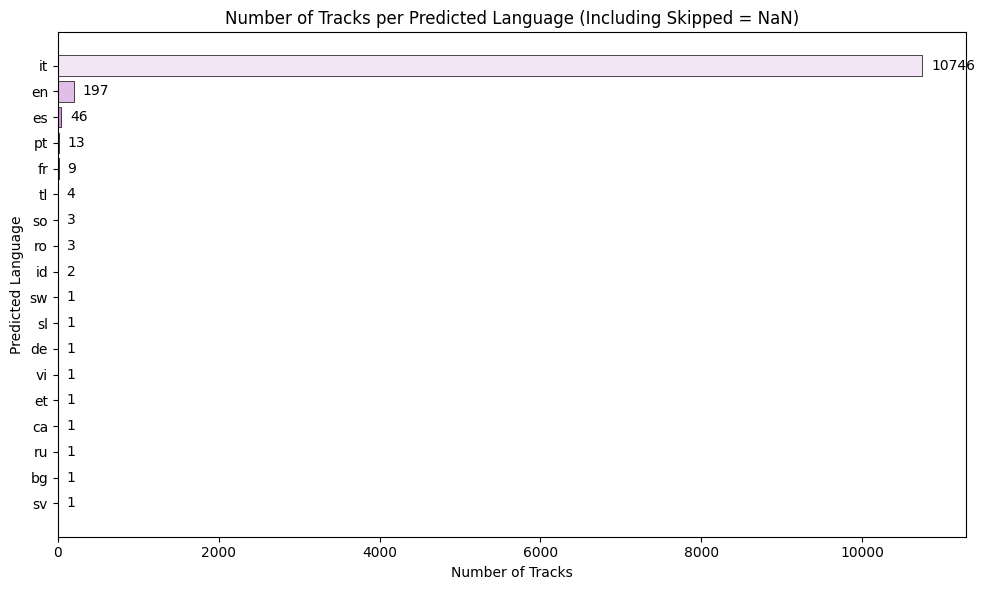

In [432]:
# --- 1) Conta lingue includendo i NaN
lang_counts = df['language'].value_counts(dropna=False).reset_index()
lang_counts.columns = ['language', 'count']

# Mostra "NaN" come etichetta senza toccare df
lang_counts['language'] = lang_counts['language'].astype(object).where(
    ~lang_counts['language'].isna(), 'NaN'
)

# Ordina per count decrescente
lang_counts = lang_counts.sort_values('count', ascending=False).reset_index(drop=True)

# --- 2) Palette (simile all'Altair che avevi)
base_palette = ["#f3e5f5", "#e1bee7", "#ce93d8", "#ba68c8", "#9c27b0"]
# se le categorie sono più di 5, cicla i colori
palette = list(islice(cycle(base_palette), len(lang_counts)))

# --- 3) Plot (barh ordinato)
plt.figure(figsize=(10, 6))
bars = plt.barh(
    y=lang_counts['language'],
    width=lang_counts['count'],
    color=palette,
    edgecolor='black',
    linewidth=0.5
)

# Inverti asse Y per avere la lingua più frequente in alto
plt.gca().invert_yaxis()

plt.xlabel('Number of Tracks')
plt.ylabel('Predicted Language')
plt.title('Number of Tracks per Predicted Language (Including Skipped = NaN)')

# --- 4) Aggiungi etichette con i conteggi alla fine delle barre
for bar, val in zip(bars, lang_counts['count']):
    x = bar.get_width()
    y = bar.get_y() + bar.get_height() / 2
    plt.text(x + max(lang_counts['count']) * 0.01, y, str(val), va='center')

plt.tight_layout()
plt.show()

In [433]:
display(df.loc[df['language']== "en", ['title', 'lyrics', 'language',]].head(50))

title                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

In [434]:
df.loc[[41, 291, 376, 730, 866, 880, 885, 952, 963, 1006, 1035, 1049, 1061, 1065, 1194, 1264, 1285, 1483,1722, 1735, 1842, 1945, 2500, 2557,2572, 2602, 2904, 2963, 3007, 3017, 3034, 3045,3069,3096, 3266, 3404, 3503, 3924, 4301, 4367,4886, 5003, 5005, 5007, 5008, 5034, 5050, 5069, 5076, 5081, 5234, 6777,7474, 7720, 8967, 8981, 9214, 9229, 9727, 9920, 9985, 10432], "predicted_language"] = "it"

display(df.loc[df['language']== "en", ['name', 'lyrics', 'language',]].head(50))

name                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

In [435]:
df.loc[[3601], "predicted_language"] = "it"

display(df.loc[df['language']== "es", ['name', 'lyrics', 'language',]].head(50))

,name,lyrics,language
684,nerone,"Te lo cuento aquí sentado mientras me escuchas rapear\r\nCuando voy al Domino's ya no me suelen hablar solo con los gestos yo me puedo comunicar\r\nPizza con piña? Pizza con piña, codo codo, guiño guiño, no hace falta decir más\r\nCon un gesto la preparan, con el otro me la sacan, la pruebo y... espectacular\r\nYo siempre vengo cual gordo fiel aquí, hace mucho que con esto yo me definí\r\nPorque siendo sinceros quien coño quiere una ensalada cuando por 9'25 tienes hawaiana\r\nEs que me cago en Dios, piña dulce y fresca\r\nQue coño haces sentado cuando puedes unirte a la fiesta\r\nY a la gente que la piña no se la pone erecta puedo entenderlo pues hay personas imperfectas\r\nY es que la piña tiene sus propiedades además de ser sana, rica y para todas las edades\r\nEs antiinflamatoria, resulta beneficiosa en casos de artritis o alguna otra cosa\r\nSu fibra ayuda al organismo porque no hay nada mejor que cagar y sentirte tu mismo\r\n\r\nSus minerales son potasio, fósforo y hasta manganeso, que supongo yo ayudará a temas de huesos y eso\r\nPero que bueno que si con esto no te he convencido no hay nada más que hacer, píllate una silla y mírame comer\r\nY que si viendo como me lo gozo con la hawaiana no te corres man es que algo en tu cerebro no funciona bien",es
758,babaman,violence\r\n rastaman\r\nI don't,es
929,guè pequeno,"Ragga, ragga\r\nEsto es como un ragga muffin, pero sin velo\r\nCabrones, no es lo mismo tú llamarlo que verlo\r\nJamaica, nos fumamos un sheika\r\nY andamos con la (Prrru) dentro de la discoteca\r\nTraje ochentas con láser, cuarentas con el mickey\r\nMe dicen Ricky Rozay, Rozay, yo como Ricky\r\nBomboclat, vamo' a ver que e' lo que tú das\r\nCuando me veas con el negro monta'o en el Cadillac\r\nY esto es un fuletazo, dos fuletazos\r\nTres por si las mocas, y cuatro por si acaso\r\nEn el brazo la roleta, la glopeta\r\nTu nombre con Magic Marker en todas las balas huecas\r\nMe dicen ""Hollow-Point"", donde apunto les unto\r\nPrimero hacé ""Click-clack"", y después es que pregunto\r\n¿Los tuyos o los míos?, ¿los míos? Aborreci'os\r\nNo aguantan el calentón, pero agárrate de este frío (Prrr)\r\n\r\nUno, due, tre, quattro, cinque\r\nVengo dall'Italia, dove la gente delinque\r\nQuattro, cinque, sei, sette, otto\r\nCuba e Porto Rico, corri quando senti il botto\r\n\r\nPa-pa-ta-ta\r\nPa-pa-ta-ta\r\nPa-pa-ta-ta\r\nI'm gonna chase you\r\nChase you\r\n\r\n(G-U-E)\r\nLei mi dice: ""Oh my God, you look so gangster""\r\nLa scopo, lei lo dice a tutto il suo quartiere (Ah-ah)\r\nItaliano, ma lei dice che sembro albanese\r\nSL in tuta Ellesse, in pace (yeah)\r\nTengo un AK sotto l'accappa Versace (rrat!)\r\nLa mafia in tuta Robe di Kappa, le piace\r\nChe sono portato per le lingue (Ah ah)\r\nPerché questi soldi ne parlano anche cinque (Uo)\r\nGuardo l'Audemars Piguet\r\nA ore tre due cavalle\r\nA ore sei la gente mia mi guarda le spalle (Se!)\r\nA ore nove tu che mi odi sempre attorno (Se!)\r\nFai un Ave Maria per arrivare a mezzogiorno (Ah-ah)\r\nMe ne fotto se mi ami\r\nHo una catena cubana e una cubana a Miami\r\nCinta nera, Miyagi (Uauu)\r\n'Sto flow, 44 KO come Mike\r\nNon lo dico io, cabrón, l'ha detto Spotify\r\n\r\nUno, due, tre, quattro, cinque\r\nVengo dall'Italia, dove la gente delinque\r\nQuattro, cinque, sei, sette, otto\r\nCuba e Porto Rico, corri quando senti il botto\r\n\r\nPa-pa-ta-ta\r\nPa-pa-ta-ta\r\nPa-pa-ta-ta\r\nI'm gonna chase you\r\nChase you\r\n\r\nSí, bro', lo que tú querías se acabó\r\nY lo que quedaba el negro se lo llevó\r\nSoy yo, el de la .38 cañon corto\r\nQue ando lleno 'e humo, que fumo y no me soporto\r\nSin licencia de portación pero la porto\r\nLlego a party con el Coscu' y no me comporto\r\nEl problema es que la fiesta es tuya y los dueños somos nosotros\r\nY portate bien sino te lleva el de la moto (Prrru)\r\nY siente uno, dos, tres, cuatro, cinco\r\nEsto no lleva balas, mato con un flow distinto\r\nYo sigo to' los días lindo, hasta los domingos\r\nY en t

#### Correcting wrong active start
Upon Inspection on the age of the artists when they started their career (code above).

Among the unique artists, several had unusual ages at career start.  Nesli (age 10)  had incorrect active start dates, while Salmo (age 13) thasup (Age 14) nitro (age 14)  ghemon (age 14 )and Mudimbi (age 27) were correct.   These values comes from the original data.

After filling birthdate and Active start date we realized that (bigmama) started at the age of one which is obviously wrong.

We have age (7) it was for the singer priestess, but we already corrected its data above in the section (Correcting "Priestess" Entry).

 We will correct the errors by updating  Nesli’s to 1999,bigmama to 2016, leaving Salmo and Mudimbi unchanged.

In [436]:
# Calculate age at career start without adding a column
ages = df['active_start'].dt.year - df['birth_date'].dt.year

# Filter rows where age is 1,7  10,  13,or 27
outliers = df[ages.isin([1,7 ,10, 13,14,27,])].copy()

# Keep only unique artists based on name
unique_outliers = outliers.drop_duplicates(subset=['name'])

print(unique_outliers[['name', 'birth_date', 'active_start']].assign(age_at_start=ages))

         name birth_date active_start  age_at_start
198    thasup 2001-03-17   2015-01-01          14.0
685   babaman 1975-08-08   1989-01-01          14.0
1128  mudimbi 1986-10-17   2013-01-01          27.0
3182   ghemon 1982-04-01   1996-01-01          14.0
6458  bigmama 2000-03-10   2001-01-01           1.0
6645    nesli 1980-12-29   1990-01-01          10.0
9608    salmo 1984-06-29   1997-01-01          13.0
9898    nitro 1993-02-11   2007-01-01          14.0


         name birth_date active_start
6458  bigmama 2000-03-10   2016-01-01
6459  bigmama 2000-03-10   2016-01-01
6460  bigmama 2000-03-10   2016-01-01
6461  bigmama 2000-03-10   2016-01-01
6462  bigmama 2000-03-10   2016-01-01
6463  bigmama 2000-03-10   2016-01-01
6464  bigmama 2000-03-10   2016-01-01
6465  bigmama 2000-03-10   2016-01-01
6466  bigmama 2000-03-10   2016-01-01
6467  bigmama 2000-03-10   2016-01-01
6468  bigmama 2000-03-10   2016-01-01
6469  bigmama 2000-03-10   2016-01-01
6470  bigmama 2000-03-10   2016-01-01
6471  bigmama 2000-03-10   2016-01-01
6472  bigmama 2000-03-10   2016-01-01
6473  bigmama 2000-03-10   2016-01-01
6474  bigmama 2000-03-10   2016-01-01
6475  bigmama 2000-03-10   2016-01-01
6476  bigmama 2000-03-10   2016-01-01
6477  bigmama 2000-03-10   2016-01-01
6478  bigmama 2000-03-10   2016-01-01
6479  bigmama 2000-03-10   2016-01-01
6480  bigmama 2000-03-10   2016-01-01
6481  bigmama 2000-03-10   2016-01-01
6482  bigmama 2000-03-10   2016-01-01
6483  bigmam

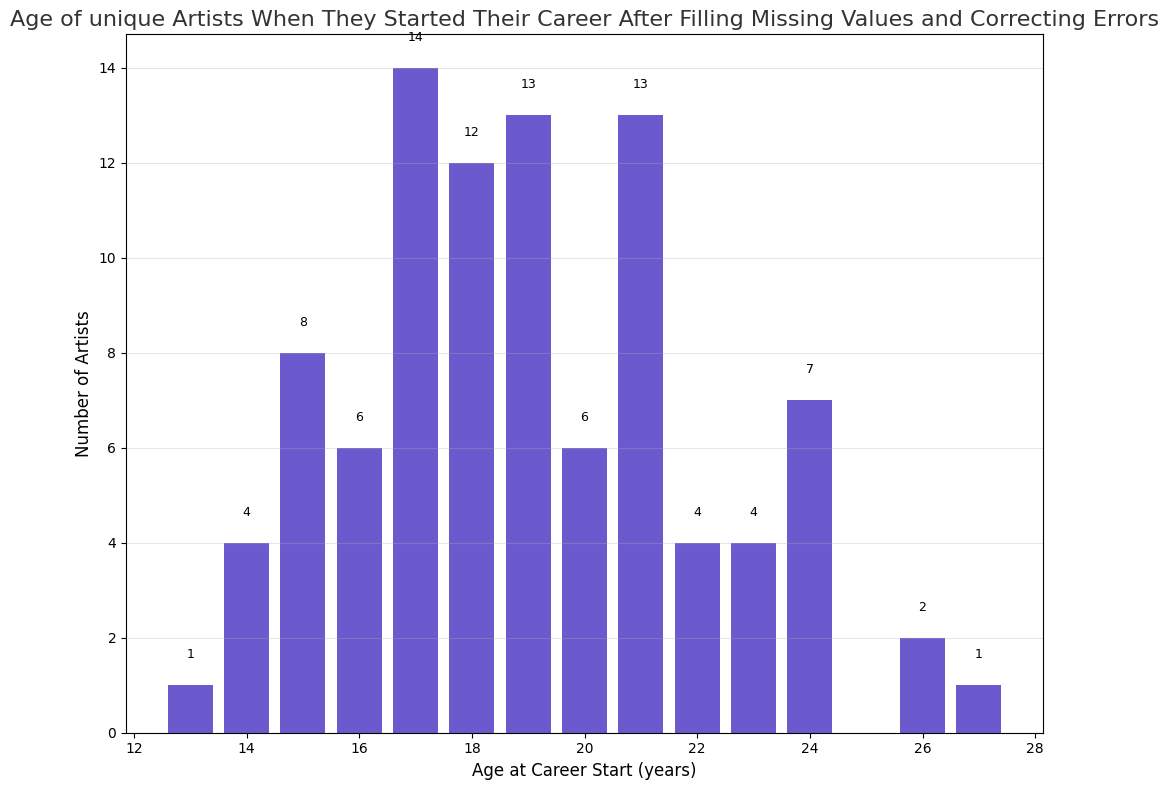

In [437]:
# Correcting wrong active_start dates
df.loc[df['name'] == 'bigmama', 'active_start'] = pd.to_datetime('2016-01-01')
df.loc[df['name'] == 'nesli', 'active_start'] = pd.to_datetime('1999-01-01')

# Verify the changes
outliers_corrected = df[df['name'].isin(['bigmama', 'nesli', 'salmo',])]
print(outliers_corrected[['name', 'birth_date', 'active_start']])
functions.plot_age_at_career_start(df,'Age of unique Artists When They Started Their Career After Filling Missing Values and Correcting Errors')

#### Correcting album release dates for albums that have multiple release dates

In [438]:

# --- 2. Compute the recent date per album ---
earliest_dates = (
    df.groupby('album', as_index=False)['album_release_date']
    .max()
)

# --- 3. Merge back into the main dataframe ---
df = df.drop(columns=['album_release_date']).merge(
    earliest_dates,
    on='album',
    how='left'
)

# --- 4. Confirm result ---
print("Replaced albums with multiple release dates by their recent  date.")
print(df[['album', 'album_release_date']].drop_duplicates().shape)
display(df[['album', 'album_release_date']].drop_duplicates())


Replaced albums with multiple release dates by their recent  date.
(886, 2)


,album,album_release_date
0,FOREVER AND EVER,2021-04-09
3,OKAY OKAY !! - EP,2025-05-16
8,Festival di Sanremo 2023,2023-02-09
10,NaN,NaT
31,OKAY OKAY 2 - EP,2025-05-16
57,Paranoise Mixtape,2023-10-06
63,One Take FM Free Mic - Season 6,2025-06-06
69,"RED BULL 64 BARS, The Album",2021-05-27
73,Crisalide,2021-10-21
104,Joker Mixtape,2025-04-04


#### Handling albums from 50s till 80s

As we inspected before, we found that all the albums from the 1950s to 1980s were incorrectly assigned — their tracks and artists do not actually belong to those albums. Because this data is unreliable, we decided to fill the columns album_name, album_release_year, and album_type with None (null values) for these records.

We do this to remove incorrect associations and avoid misleading results in future analysis. By replacing these wrong values with None, we clearly mark them as invalid or unknown, ensuring that only verified album–artist–track relationships remain in the dataset.

In [ ]:

import importlib
import project_fuctions
importlib.reload(project_fuctions)
functions.plot_unique_album_release_distribution(df)
def fix_corrupted_release_dates(df):
    """
    Fixes corrupted album release dates by imputing them with the verified modern release dates,
    including month and day, and casts the column to datetime objects.
    """
    df = df.copy() 
    
    # 1. Define the Master Mapping Dictionary: {Album Name: Correct Date String (YYYY-MM-DD)}
    CORRECT_DATE_MAP = {
        'K1 Mixtape': '2014-12-29',
        'S.O.S. EP': '2008-10-16',
        'Entics Television': '2014-01-01',    # Using YYYY-01-01 for unknown M/D
        'Cracovia': '2016-01-01',             # Using YYYY-01-01 for unknown M/D
        'Council Estate Vol.1': '2012-01-01',   # Using YYYY-01-01 for unknown M/D
        'Happy EP!': '2011-05-03',
        'Equilibrio - EP': '2010-06-07',
        'Jolly Mixtape': '2017-11-07',
        'Quello Che Vi Consiglio Vol. 4': '2013-10-18',
        'Rimo Da Quando': '2010-11-15',
        'Nobiltà di Strada': '2007-02-16',
        'Vivere aiuta a non morire': '2013-04-30',
        'Quattro San Simoni e un funerale EP': '2015-04-28',
        'VERA BADDIE': '2024-06-28',
        'Haterproof': '2011-10-15',
        'Tutto il Contrario Remixtape': '2011-01-01', # Using YYYY-01-01 for unknown M/D
        'Radiografia - EP': '2006-01-01',    # Using YYYY-01-01 for unknown M/D
    }
    
    # 2. Apply the Mapping and Overwrite Corrupted Dates
    is_corrupted_row = df['album'].isin(CORRECT_DATE_MAP.keys())
    df.loc[is_corrupted_row, 'album_release_date'] = df.loc[is_corrupted_row, 'album'].map(CORRECT_DATE_MAP)
    
    # # 3. Final Cleaning: Cast the column to datetime objects
    df['album_release_date'] = pd.to_datetime(df['album_release_date'], errors='coerce')
    
    print("### ✅ Full Release Date Imputation Complete")
    print(f"Corrected {is_corrupted_row.sum()} records with precise dates.")

    return df


fix_corrupted_release_dates(df)
functions.plot_unique_album_release_distribution(df,
                                                 
    title1="Percentage of Unique Albums by Release Decade After Cleaning",
    title2="Distribution of Unique Album Release Years After Cleaning",)

TypeError: plot_unique_album_release_distribution() missing 2 required positional arguments: 'title1' and 'title2'

#### Cleaning Albums Released Before the Artist’s Birth

In [ ]:
# Create a mask for albums released before the artist was born
mask = (df['album_release_date'] < df['birth_date'])

# Nullify incorrect album information
df.loc[mask, ['album_name', 'album_release_date', 'disc_number','track_number']] = np.nan

# Confirm how many records were affected
print(f"Albums released before artist's birth: {mask.sum()} records cleaned.")
df.loc[mask, ['name', 'album_name', 'album_release_date', 'birth_date', 'album_type','disc_number','track_number']]


Albums released before artist's birth: 2 records cleaned.


,name,album_name,album_release_date,birth_date,album_type,disc_number,track_number
2945,rondodasosa,NaN,NaT,2002-04-29,album,NaN,NaN
10031,shiva,NaN,NaT,1999-08-27,album,NaN,NaN


#### Renumbering Duplicates Track Numbers

In [ ]:
# Clean up strings (optional but helpful)
df['album'] = df['album'].str.strip()
df['title'] = df['title'].str.strip()
df['name'] = df['name'].str.strip()

# Sort to maintain consistent order
df = df.sort_values(['album', 'disc_number', 'track_number']).reset_index(drop=True)

# Renumber duplicate track numbers within each album/disc group
def renumber_duplicates(group):
    # Count duplicates of track_number within this disc
    counts = group['track_number'].value_counts()
    duplicates = counts[counts > 1].index

    if len(duplicates) > 0:
        # Reassign track numbers so that each entry within a disc has unique numbers starting at 1
        group['track_number'] = range(1, len(group) + 1)
    return group

df = df.groupby(['album', 'disc_number'], group_keys=False).apply(renumber_duplicates)


duplicates = df[df.duplicated(subset=['album', 'disc_number', 'track_number'], keep=False)]
print(f"🎵 Found {len(duplicates)} duplicate track entries.")
dtale.show(duplicates[['album', 'disc_number', 'track_number', 'title', 'name']])


AttributeError: Can only use .str accessor with string values!

#### Correcting Coordinates
We will correct coordinates to make them match the birth_place

In [ ]:
# Correct coordinates for each birth place
coord_map = {
    "Almería": (36.8340, -2.4637),
    "Buenos Aires": (-34.6037, -58.3816),
    "Singapore": (1.290270, 103.851959)
}

# Update each row based on exact city name
for place, (lat, lon) in coord_map.items():
    mask = df['birth_place'] == place
    df.loc[mask, 'latitude'] = lat
    df.loc[mask, 'longitude'] = lon

# Keep only the columns we care about
cols = ['birth_place', 'latitude', 'longitude','province','region']

# Drop duplicates so each place appears once (keeping the first lat/lon found)
unique_places = df[cols].drop_duplicates(subset=['birth_place'])

# Sort alphabetically by birth_place (optional)
unique_places = unique_places.sort_values(by='birth_place').reset_index(drop=True)

# Display results
display(unique_places)



,birth_place,latitude,longitude,province,region
0,Almería,36.834000,-2.463700,Genova,Liguria
1,Alpignano,45.095724,7.525403,Torino,Piemonte
2,Avellino,40.996545,15.140569,Avellino,Campania
3,Bologna,44.493820,11.342633,Bologna,Emilia-Romagna
4,Brescia,45.779580,10.425873,Brescia,Lombardia
5,Buenos Aires,-34.603700,-58.381600,NaN,NaN
6,Cagliari,39.217199,9.113311,Cagliari,Sardegna
7,Desenzano del Garda,45.469485,10.538947,Brescia,Lombardia
8,Firenze,43.769796,11.255640,Firenze,Toscana
9,Fiumicino,41.771214,12.227885,Roma,Lazio


#### Fixing Explicit

In [ ]:
print("\nApplying new rule: 'explicit' = (swear_IT > 0) | (swear_EN > 0)")
new_explicit_mask = (df['swear_IT'] > 0) | (df['swear_EN'] > 0)

# --- 3. Overwrite the 'explicit' Column ---
# We replace the original 'explicit' values with our new, consistent rule.
df['explicit'] = new_explicit_mask

print("\n'explicit' column successfully overwritten.")
print("\nNew 'explicit' values (After standardization):")
print(df['explicit'].value_counts())

# --- 4. Verification ---
print("\n--- Verification ---")
print("Checking for rows where 'explicit = True' but swear count is 0 (should be 0):")

# Find any errors (where explicit is True, but both swear counts are 0)
errors = df[(df['explicit'] == True) & (df['swear_IT'] == 0) & (df['swear_EN'] == 0)]
num_errors = len(errors)

print(f"Errors found: {num_errors}")

if num_errors == 0:
    print("SUCCESS: The 'explicit' column is now 100% consistent with swear counts.")
else:
    print("ERROR: Discrepancies still found. Please review the logic.")

print("\n(Note: The 1,202 'explicit-for-other-reasons' cases are now set to False.)")
print("(Note: The 3,125 'not-explicit-with-swears' cases are now set to True.)")


Applying new rule: 'explicit' = (swear_IT > 0) | (swear_EN > 0)

'explicit' column successfully overwritten.

New 'explicit' values (After standardization):
explicit
True     7531
False    3404
Name: count, dtype: int64

--- Verification ---
Checking for rows where 'explicit = True' but swear count is 0 (should be 0):
Errors found: 0
SUCCESS: The 'explicit' column is now 100% consistent with swear counts.

(Note: The 1,202 'explicit-for-other-reasons' cases are now set to False.)
(Note: The 3,125 'not-explicit-with-swears' cases are now set to True.)


#### Fixing Duration

In [ ]:
# Define valid duration range (in milliseconds)
MIN_DUR = 30_000      # 30 seconds
MAX_DUR = 600_000    # 10 minutes

# Replace unrealistic values with NaN
df['duration_ms'] = df['duration_ms'].where(
    (df['duration_ms'] >= MIN_DUR) & (df['duration_ms'] <= MAX_DUR),
    np.nan
)

# Show songs now missing duration (i.e., invalid before)
invalid_songs = df[df['duration_ms'].isna()][['title', 'duration_ms']]
invalid_songs


,title,duration_ms
59,Collezione Megamix,NaN
60,Smoked Out,NaN
166,FM 96.97 - Ave O Maria,NaN
285,Rover*,NaN
1032,Non Sono Più Innamorato,NaN
1560,Dovete Andarvene,NaN
2538,I’m Gon Win RMX,NaN
2539,Tutti Kings Online,NaN
3121,Come gli altri,NaN
3143,VOCE (ACOUSTIC VERSION) (AMAZON ORIGINAL),NaN


### Fixing Outliers

### Save new cleaned dataset

In [ ]:
output_folder = "data"
output_file = "merge_dataset_cleaned.csv"
output_filename = os.path.join(output_folder, output_file)

print(f"--- Saving Cleaned DataFrame ---")
print(f"Saving {len(df)} rows and {len(df.columns)} columns to '{output_filename}'...")

try:
    df.to_csv(output_filename, index=False)

    print(f"\nSUCCESS: DataFrame saved successfully to '{output_filename}'.")

except Exception as e:
    print(f"\nERROR: An error occurred while saving the file.")
    print(f"Error details: {e}")

--- Saving Cleaned DataFrame ---
Saving 10935 rows and 50 columns to 'data\merge_dataset_cleaned.csv'...

SUCCESS: DataFrame saved successfully to 'data\merge_dataset_cleaned.csv'.
